In [1]:
%load_ext Cython 
import numpy as np
import random, time
from multiprocessing import Pool, freeze_support
from io import StringIO
import itertools,time
import matplotlib.widgets as widgets
%pylab inline
def linlin(x, smi, sma, dmi, dma): return (x-smi)/(sma-smi)*(dma-dmi)+dmi
from threading import Thread

# Audio server
from pyo import *
# Is 1024 too large for the bufferSize in this case. 
fs = 44100/2
s = Server(sr=fs, nchnls=2, buffersize=2048, duplex=0).boot()
s.start()

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [2]:
# Audio playback function
# The old version
def playvec(data, dataLen, fs,  rate=1.0, amp=0.5):
    #Create a new table for recording. 
    # length is in seconds.
#     t = NewTable(length= len(data)/fs , chnls=1)
    t = DataTable(size = len(data), chnls = 1)
    t.replace(list(data))
    # Create an oscillator
    c = Osc(table=t, freq=[ 1.0/(dataLen + 0.2) * rate, 1.0/(dataLen + 0.2) * rate], mul=amp)
    c = Compress(c,thresh = -20, ratio = 3, risetime = .01, falltime = .2, knee = 0.5 ).out()
    time.sleep((dataLen + 0.1)/rate)
#     c.stop()

class playAudioNoThread:       
    def __init__(self, sampling_rate, dataLen = 1.0,  play_back_rate = 1.0, bs = 44100, amp = 0.5):
#         audioVec = np.zeros(bufferSize)
        self.sf = sampling_rate
        self.rate = play_back_rate
        self.amp = amp
        self.bs = int(bs)
        self.dataLen = dataLen
        self.t = DataTable(size =self.bs, chnls=1)  # Data table
        self.c = Osc(table=self.t, freq=[ 1.0/self.dataLen * self.rate, \
                                         1.0 / self.dataLen * self.rate],\
                     mul=self.amp).out() # Table playback. 

    def looping(self, audioVec):
        # Continous mode
        self.t.replace(list(audioVec))
        self.c.setTable(self.t)
    
    def single(self, audioVec):
        # Currently no add silence. Need to do so. 
        self.t = DataTable(size =self.bs, chnls=1)  # Data table
        self.c = Osc(table=self.t, freq=[ 1.0/self.dataLen * self.rate, \
                                         1.0 / self.dataLen * self.rate],\
                     mul=self.amp).out() # Table playback. 
        self.t.replace(list(audioVec))
        self.c.setTable(self.t)
        time.sleep(self.dataLen/self.rate)
        self.c.stop()
        
    def stopAudio(self):
        self.c.stop()

In [3]:
# Create a rigid window to ramp on/off the audio vector to prevent clipping. 
# But I still hear clipping. 
def makeWindow(s, rampUp = 0.02, rampDown = 0.02):
    w = np.append(np.linspace(0, 1.0, num = int(s * rampUp)), \
      np.ones(s - int(s * rampUp)- int(s * rampDown)))
    w = np.append(w, np.linspace(1.0, 0, num = int(s * rampDown)))
    return w

# Turn list into integer
def list2int(numbers):
    return int(''.join([ "%d"%x for x in numbers]))

# Add some silence to the end
def addSilence(av, bs = 5000):
    return np.append(av, np.zeros(0.2 * bs))

# Slider update function, for the interaction
def sliderUpdate(val):
    global dt, resistant
    sigma = ssigma.val
    exp_table = updateExpTable(sigma, delta_dis)
    dt = sdt.val
    resistant = sresistant.val
    
def sigmaUpdate(val):
    global sigma, exp_table, delta_dis
    sigma = ssigma.val
    exp_table = updateExpTable(sigma, delta_dis)
    
# Create an exponential table for the lookup calculation of potential. 
def createExpTable( dim, sigma, exp_resolution = 1000000 ):
    delta_dis = np.linspace(0.0, dim, num = exp_resolution) # Range of distance difference. 
    tab = updateExpTable(sigma, delta_dis)
    return tab, dim

def updateExpTable(sigma, delta_dis):
    sigma2 = sigma * sigma
    return exp(- delta_dis/sigma2)/sigma2

In [4]:
# Currently this plotpot is only for interactive mode. 
# Eventually, data visualisation is not needed because it is aimed just for the sonification. 
# Data visualisation can be provided offline as a comparison. 
# For this method, visulisation is no use for higher dimension data anytaway 
def plotpot(data2d, fig2, sigma=.1, Nx=40, Ny=40):
    # ensure the data sending for plotpot is always in 2d. 
    potmap = zeros((Nx, Ny))
    for i in range(Nx):
        for j in range(Ny):
            x = float(i)/Nx-0.5
            y = float(j)/Ny-0.5
            potmap[j,i] = potential_ds(data2d, np.array([x,y]), sigma)
    fig2.clf()
    matshow(potmap, cmap=cm.gray, extent=(-0.5,0.5,0.5,-0.5), fignum = 2)    
    fig2.gca().plot(data[:,0], data[:,1], ".")

def initializePot(data, N):  # It takes data and number of rows. 
    sctPlot = ax.scatter(data[:,0], data[:,1],  c="blue", picker = 2, s=[50]*N)
    fig.subplots_adjust(bottom=0.2, left=0.1)
    plt.grid(False)
    plt.axis([-0.6, 0.6, -0.6, 0.6])
    return sctPlot
    
def plotpot2(data2d, fig, sigma=.1, Nx=40, Ny=40, figure_num = 1):
    # ensure the data sending for plotpot is always in 2d.    
    potmap = zeros((Nx, Ny))
    for i in range(Nx):
        for j in range(Ny):
            x = float(i)/Nx-0.5
            y = float(j)/Ny-0.5
            potmap[j,i] = potential_ds(data2d, np.array([x,y]), sigma)
    matshow(potmap, cmap=cm.gray, extent=(-0.5,0.5,0.5,-0.5), fignum = figure_num) 
    return potmap

def spectrum(av,fs):
    NFFT = 1024
    figure()
    specgram(audioVec, NFFT = NFFT, Fs = fs, noverlap = 900, cmap= cm.gist_heat)
    show()
    
def stdData(data, dim):
    for i in range(dim):
        # S1 Standardize data. 
        data[:, i] = (data[:,i] - np.mean(data[:,i]))/np.std(data[:,1])
        # limit range to -.5 ~ .5 in each dimension
        data[:,i] = data[:,i] / np.max(np.absolute(data[:,i]))
        data[:,i] = data[:,i] / 2  
    return data
    

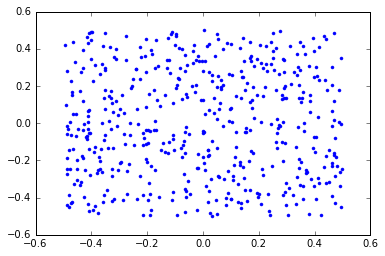

In [5]:
# if testMode == T, a random example is used as the data. 
# else, you can load the actual data txt files. 
testMode = True
if testMode == True:
    data = np.random.rand(500,2)-[0.5,  0.5]
    N, dim = data.shape[0], data.shape[1]
    plot(data[:,0], data[:,1], ".")

else:
    # Load test data from file 
#     data = np.loadtxt("data/dim032.txt")
    # Still have problem loading csv file. 
    data = np.genfromtxt("data/posture.csv",delimiter=",", skip_header = 1)
    headers = np.genfromtxt("data/posture.csv", dtype = np.str_, delimiter = ",", max_rows = 1 )
    N, dim = data.shape[0], data.shape[1]
#     data = stdData(data, dim)
#     plot(data[:,0], data[:,1], ".")



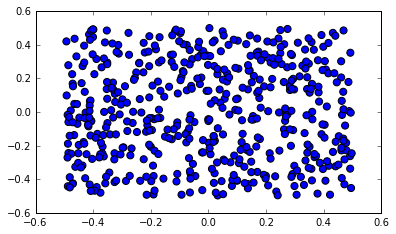

In [7]:
fig, ax = plt.subplots()
# Initialize the plot windows. 
sctPlot = initializePot(data, N)